In [ ]:
from google.colab import drive
drive.mount('/content/drive')

This section of code extracts frames from videos and stores them in the same folder where the video is stored. At the same time, it creates a metadata named data_file.csv that stores information like name of the video file, number of frames, class name and whether it is train or test dataset.

In [ ]:
import csv
import glob
import os.path
from subprocess import call
import os
from random import shuffle

def extract_files():
    data_file = []
    folders = ['train', 'test']
    for folder in folders:
        class_folders = glob.glob(os.path.join(folder, '*'))

        for vid_class in class_folders:
            class_files = glob.glob(os.path.join(vid_class, '*.mp4'))
            # print(class_files)

            for video_path in class_files:
                # Get the parts of the file.
                video_parts = get_video_parts(video_path)

                train_or_test, classname, filename_no_ext, filename = video_parts

                # Only extract if we haven't done it yet. Otherwise, just get
                # the info.
                if not check_already_extracted(video_parts):
                    # Now extract it.
                    src = os.path.join(train_or_test, classname, filename)
                    dest = os.path.join(train_or_test, classname,
                        filename_no_ext + '-%04d.jpg')
                    call(["ffmpeg", "-i", src, dest])

                # Now get how many frames it is.
                nb_frames = get_nb_frames_for_video(video_parts)

                data_file.append([train_or_test, classname, filename_no_ext, nb_frames])

                print("Generated %d frames for %s" % (nb_frames, filename_no_ext))
    shuffle(data_file)

    with open('data_file.csv', 'w') as fout:
        writer = csv.writer(fout)
        writer.writerows(data_file)
    #[train|test], class, filename, nb frames
    print("Extracted and wrote %d video files." % (len(data_file)))

def get_nb_frames_for_video(video_parts):
    train_or_test, classname, filename_no_ext, _ = video_parts
    generated_files = glob.glob(os.path.join(train_or_test, classname,
                                filename_no_ext + '*.jpg'))
    return len(generated_files)

def get_video_parts(video_path):
    parts = video_path.split(os.path.sep)
    filename = parts[2]
    filename_no_ext = filename.split('.')[0]
    classname = parts[1]
    train_or_test = parts[0]

    return train_or_test, classname, filename_no_ext, filename

def check_already_extracted(video_parts):
    train_or_test, classname, filename_no_ext, _ = video_parts
    return bool(os.path.exists(os.path.join(train_or_test, classname,
                               filename_no_ext + '-0001.jpg')))

extract_files()

This section of code generates features from overall frames using transfer learning and stores them using numpy in "data/sequences" folder

In [ ]:
import csv
import numpy as np
import random
import glob
import os.path
import sys
import operator
import threading
from tensorflow.keras.utils import to_categorical
class DataSet():

    def __init__(self, seq_length=40, class_limit=None, image_shape=(224, 224, 3)):
        self.seq_length = seq_length
        self.class_limit = class_limit
        self.sequence_path = os.path.join('data', 'sequences')
        self.max_frames = 300  # max number of frames a video can have for us to use it
        self.data = self.get_data()
        self.classes = self.get_classes()
        self.data = self.clean_data()
        self.image_shape = image_shape
        os.makedirs("data/sequences",exist_ok=True)


    @staticmethod
    def get_data():
        with open(os.path.join('data_file.csv'), 'r') as fin:
            reader = csv.reader(fin)
            data = list(reader)
        return data

    def clean_data(self):
        data_clean = []
        for item in self.data:
            if int(item[3]) >= self.seq_length and int(item[3]) <= self.max_frames \
                    and item[1] in self.classes:
                data_clean.append(item)

        return data_clean

    def get_classes(self):
        classes = []
        for item in self.data:
            if item[1] not in classes:
                classes.append(item[1])
        classes = sorted(classes)
        if self.class_limit is not None:
            return classes[:self.class_limit]
        else:
            return classes

    def get_class_one_hot(self, class_str):
        # Encode it first.
        label_encoded = self.classes.index(class_str)
        # Now one-hot it.
        label_hot = to_categorical(label_encoded, len(self.classes))
        assert len(label_hot) == len(self.classes)
        return label_hot

    def split_train_test(self):
        train = []
        test = []
        for item in self.data:
            if item[0] == 'train':
                train.append(item)
            else:
                test.append(item)
        return train, test

    def get_all_sequences_in_memory(self, train_test, data_type):
        train, test = self.split_train_test()
        data = train if train_test == 'train' else test

        print("Loading %d samples into memory for %sing." % (len(data), train_test))

        X, y = [], []
        for row in data:
            sequence = self.get_extracted_sequence(data_type, row)
            if sequence is None:
                print("Can't find sequence. Did you generate them?")
                raise
            X.append(sequence)
            y.append(self.get_class_one_hot(row[1]))
        return np.array(X), np.array(y)

    def get_extracted_sequence(self, data_type, sample):
        filename = sample[2]
        path = os.path.join(self.sequence_path, filename + '-' + str(self.seq_length) + \
            '-' + data_type + '.npy')
        if os.path.isfile(path):
            return np.load(path)
        else:
            return None

    def get_frames_by_filename(self, filename, data_type):
        sample = None
        for row in self.data:
            if row[2] == filename:
                sample = row
                break
        if sample is None:
            raise ValueError("Couldn't find sample: %s" % filename)
        sequence = self.get_extracted_sequence(data_type, sample)
        if sequence is None:
            raise ValueError("Can't find sequence. Did you generate them?")
        return sequence

    @staticmethod
    def get_frames_for_sample(sample):
        """Given a sample row from the data file, get all the corresponding frame
        filenames."""
        path = os.path.join(sample[0], sample[1])
        filename = sample[2]
        images = sorted(glob.glob(os.path.join(path, filename + '*jpg')))
        return images

    @staticmethod
    def rescale_list(input_list, size):
        assert len(input_list) >= size
        skip = len(input_list) // size
        output = [input_list[i] for i in range(0, len(input_list), skip)]
        return output[:size]


import numpy as np
import os.path
from keras.preprocessing import image as Img
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model, load_model
from keras.layers import Input
from tqdm import tqdm

seq_length=40

# Get the dataset.
data = DataSet(seq_length=40, class_limit=None)

base_model = InceptionV3(
    weights='imagenet',
    include_top=True
)
# We'll extract features at the final pool layer.
model = Model(
    inputs=base_model.input,
    outputs=base_model.get_layer('avg_pool').output
)

# Loop through data.
pbar = tqdm(total=len(data.data))
for video in data.data:

    # Get the path to the sequence for this video.
    path = os.path.join('data', 'sequences', video[2] + '-' + str(seq_length) + \
        '-features')  # numpy will auto-append .npy
    # Check if we already have it.
    if os.path.isfile(path + '.npy'):
        pbar.update(1)
        continue

    # Get the frames for this video.
    frames = data.get_frames_for_sample(video)
    #print(frames)

    # Now downsample to just the ones we need.
    frames = data.rescale_list(frames, 40)
    #print(frames)
    #extracting features and appending to build the sequence.
    sequence = []
    for image in frames:
        img = Img.load_img(image, target_size=(299, 299))
        x = Img.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        features = model.predict(x)
        sequence.append(features[0])

    # Save the sequence.
    np.save(path, sequence)

    pbar.update(1)

pbar.close()

This section of code trains the model and stores the checkpoints in a folder named "checkpoints" in the drive.

5
Loading 1640 samples into memory for training.
Loading 169 samples into memory for testing.
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_46 (LSTM)               (None, 40, 256)           2360320   
_________________________________________________________________
batch_normalization_24 (Batc (None, 40, 256)           1024      
_________________________________________________________________
lstm_47 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_46 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_24 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 5)                 85        
Total params: 2,560,613
T

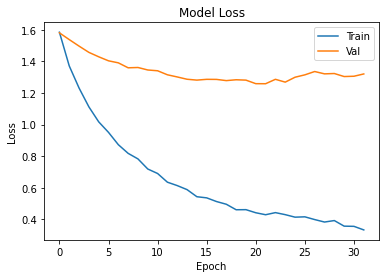

In [ ]:
from keras.layers import Dense, Flatten, Dropout, ZeroPadding3D, BatchNormalization, Bidirectional, Activation
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam, SGD
from collections import deque
import matplotlib.pyplot as plt
import sys
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger
import time
import os.path
os.makedirs("/content/drive/MyDrive/checkpoints",exist_ok=True)
checkpoint_path = "/content/drive/MyDrive/checkpoints/cp-{epoch:04d}.hdf5"
checkpointer = ModelCheckpoint(
    filepath= checkpoint_path,
    verbose=1,
    save_best_only=True)

def plot_learning_curves(history):

    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Val"], loc="upper right")
    plt.savefig("Model Loss.png")
    plt.show()

Helper: TensorBoard
tb = TensorBoard(log_dir=os.path.join('data', 'logs', 'lstm'))

# Helper: Stop when we stop learning.
early_stopper = EarlyStopping(patience=10)

# Helper: Save results.
timestamp = time.time()
csv_logger = CSVLogger(os.path.join('data', 'logs', 'lstm' + '-' + 'training-' + \
    str(timestamp) + '.log'))

# Get the data and process it.
data = DataSet(
    seq_length=40,
    class_limit=None
)
print(len(data.classes))
#listt=[]
#listt2=[]
HIDDEN_UNITS = 512
X, y = data.get_all_sequences_in_memory('train', 'features')

X_test, y_test = data.get_all_sequences_in_memory('test', 'features')

model = Sequential()

model.add(LSTM(256,return_sequences=True, input_shape=(40,2048), dropout=0.4))
model.add(BatchNormalization())
# model.add(Dropout(0.6))
model.add(LSTM(128))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(data.classes), activation='softmax'))
optimizer = Adam(lr=1e-5, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,
                    metrics=['accuracy','top_k_categorical_accuracy'])
print(model.summary())

history = model.fit(
    X,
    y,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    shuffle=True,
    callbacks=[tb, early_stopper, csv_logger, checkpointer],
    epochs=100)

plot_learning_curves(history)

This section of code tests the trained model on a single video file

In [ ]:
from keras.layers import Dense, Flatten, Dropout, ZeroPadding3D
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from collections import deque
import sys
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger
import time
import os.path

model = Sequential()
model.add(LSTM(256,return_sequences=True, input_shape=(40,2048), dropout=0.4))
model.add(BatchNormalization())
# model.add(Dropout(0.6))
model.add(LSTM(128))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(data.classes), activation='softmax'))
model.load_weights('/content/cp-0021.hdf5')


import numpy as np
import os.path
from keras.preprocessing import image as Img
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model, load_model
from keras.layers import Input
import glob

def rescale_list(input_list, size):
    assert len(input_list) >= size
    skip = len(input_list) // size
    output = [input_list[i] for i in range(0, len(input_list), skip)]
    return output[:size]
classes = ["father", "food", "promise", "tea", "wife"]
import cv2 
import os 
image_name = 'promise3.mp4'
cam = cv2.VideoCapture(image_name) 
currentframe = 0
frames = []

while(True): 
    ret,frame = cam.read() 
    if ret: 
        # if video is still left continue creating images 
        name = 'testFinal/frame'+image_name +"frame_no"+ str(currentframe) + '.jpg'
        cv2.imwrite(name, frame) 
        frames.append(name)  
        currentframe += 1
    else: 
        break
cam.release() 
cv2.destroyAllWindows() 
rescaled_list = rescale_list(frames,40)

base_model = InceptionV3(
    weights='imagenet',
    include_top=True
)
# We'll extract features at the final pool layer.
inception_model = Model(
    inputs=base_model.input,
    outputs=base_model.get_layer('avg_pool').output
)
sequence = []
for image in rescaled_list:
        img = Img.load_img(image, target_size=(299, 299))
        x = Img.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        features = inception_model.predict(x)
        sequence.append(features[0])

sequence = np.array([sequence])
prediction = model.predict(sequence)
maxm = prediction[0][0]
maxid = 0
for i in range(len(prediction[0])):
  if(maxm<prediction[0][i]):
    maxm = prediction[0][i]
    maxid = i


print(image_name,' ------- ',classes[maxid])

promise3.mp4  -------  father
